In [23]:
# Importing necessary libraries
import pandas as pd

# Load the dataset
train_data = pd.read_csv('train.csv')

# 1. Overview of the dataset
print("Dataset Overview:")
print(train_data.info())  # Provides data types and non-null counts
print("\nFirst 5 rows of the dataset:")
print(train_data.head())  # Displays the first few rows of the dataset

# 2. Summarizing unique values in each column
print("\nUnique values in each column:")
unique_values = train_data.nunique()
print(unique_values)

# 3. Detailed statistical analysis for numerical columns
print("\nStatistical analysis on numerical columns:")
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
statistics = train_data[numerical_columns].describe(percentiles=[0.25, 0.5, 0.75])
print(statistics)


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256 entries, 0 to 6255
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           6256 non-null   int64  
 1   Address         6256 non-null   object 
 2   Possesion       6256 non-null   object 
 3   Furnishing      6256 non-null   object 
 4   Buildup_area    6256 non-null   float64
 5   Carpet_area     6256 non-null   float64
 6   Bathrooms       6256 non-null   float64
 7   Property_age    6256 non-null   int64  
 8   Parking         6256 non-null   int64  
 9   Price           6256 non-null   int64  
 10  Brokerage       6256 non-null   float64
 11  Floor           6256 non-null   float64
 12  Per_sqft_price  6256 non-null   float64
 13  BHK             6256 non-null   float64
 14  Total_bedrooms  6256 non-null   float64
dtypes: float64(8), int64(4), object(3)
memory usage: 733.2+ KB
None

First 5 rows of the dataset:
   index   

In [25]:
numerical_columns

Index(['index', 'Buildup_area', 'Carpet_area', 'Bathrooms', 'Property_age',
       'Parking', 'Price', 'Brokerage', 'Floor', 'Per_sqft_price', 'BHK',
       'Total_bedrooms'],
      dtype='object')

In [26]:
# Step 1: Check the columns in the numeric dataset
print("Columns in numeric dataset:")
print(numerical_columns)  # No need for `.columns` since it's an Index object

# Step 2: Ensure the target variable column is numeric
# Replace 'price' with the actual column name if needed
target_variable = 'Price'  # Update based on the dataset
if target_variable not in numerical_columns:
    print(f"Target variable '{target_variable}' not found in numeric columns. Attempting to convert...")
    if target_variable in train_data.columns:
        # Attempt to convert the column to numeric
        train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
        numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns  # Update this to get columns after conversion
    else:
        raise ValueError(f"The column '{target_variable}' does not exist in the dataset.")

# Step 3: Recalculate correlation matrix
correlation_matrix = train_data[numerical_columns].corr()  # Make sure we calculate correlation using the updated columns
if target_variable not in correlation_matrix.columns:
    raise ValueError(f"The target variable '{target_variable}' is still not numeric or not present in the numeric dataset.")

target_correlation = correlation_matrix[target_variable]

# Step 4: Identify low correlation columns
low_correlation_columns = target_correlation[(target_correlation > -0.1) & (target_correlation < 0.1)].index.tolist()

# Step 5: Additional checks for irrelevant columns
irrelevant_columns = [col for col in train_data.columns if train_data[col].nunique() == 1 or train_data[col].isnull().mean() > 0.9]

# Combine columns to drop
columns_to_drop = list(set(low_correlation_columns + irrelevant_columns))

# Reasons for dropping
print("Reasons for dropping columns:")
for col in columns_to_drop:
    if col in low_correlation_columns:
        print(f"- '{col}' has low correlation ({target_correlation[col]:.2f}) with the target variable.")
    if col in irrelevant_columns:
        print(f"- '{col}' is irrelevant due to lack of variability or excessive missing values.")

# Drop the columns
print("\nColumns to drop:", columns_to_drop)
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# Save the cleaned dataset
train_data_cleaned.to_csv("train_cleaned.csv", index=False)


Columns in numeric dataset:
Index(['index', 'Buildup_area', 'Carpet_area', 'Bathrooms', 'Property_age',
       'Parking', 'Price', 'Brokerage', 'Floor', 'Per_sqft_price', 'BHK',
       'Total_bedrooms'],
      dtype='object')
Reasons for dropping columns:
- 'index' has low correlation (0.05) with the target variable.
- 'Possesion' is irrelevant due to lack of variability or excessive missing values.
- 'Property_age' has low correlation (0.07) with the target variable.

Columns to drop: ['index', 'Possesion', 'Property_age']


In [27]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Step 2: Initialize the label encoder
label_encoders = {}
for col in categorical_columns:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    # Fit and transform the column
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    # Save the encoder for later use (e.g., for test data)
    label_encoders[col] = le

# Step 3: Save the encoded dataset
train_data.to_csv("train_encoded.csv", index=False)
print("\nLabel encoding completed. Encoded dataset saved as 'train_encoded.csv'.")


Categorical columns: Index(['Address', 'Possesion', 'Furnishing'], dtype='object')
Encoding column: Address
Encoding column: Possesion
Encoding column: Furnishing

Label encoding completed. Encoded dataset saved as 'train_encoded.csv'.


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Identify numerical columns
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
target_variable = 'Price'  # Update based on your dataset

# Separate features and target
X = train_data[numerical_columns].drop(columns=[target_variable], errors='ignore')
y = train_data[target_variable]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 3: Train Decision Tree model without scaling
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_val)

# Evaluate performance without scaling
mse_without_scaling = mean_squared_error(y_val, y_pred)
r2_without_scaling = r2_score(y_val, y_pred)

# Step 4: Train Decision Tree model with scaling
dt_model_scaled = DecisionTreeRegressor(random_state=42)
dt_model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = dt_model_scaled.predict(X_val_scaled)

# Evaluate performance with scaling
mse_with_scaling = mean_squared_error(y_val, y_pred_scaled)
r2_with_scaling = r2_score(y_val, y_pred_scaled)

# Step 5: Print and compare results
print("Performance of Decision Tree without scaling:")
print(f"Mean Squared Error: {mse_without_scaling:.4f}")
print(f"R2 Score: {r2_without_scaling:.4f}")

print("\nPerformance of Decision Tree with scaling:")
print(f"Mean Squared Error: {mse_with_scaling:.4f}")
print(f"R2 Score: {r2_with_scaling:.4f}")

# Step 6: Analysis
if mse_without_scaling == mse_with_scaling and r2_without_scaling == r2_with_scaling:
    print("\nAnalysis: Feature scaling does not significantly impact Decision Tree performance.")
else:
    print("\nAnalysis: Scaling impacts Decision Tree performance, but this behavior is unexpected.")


Performance of Decision Tree without scaling:
Mean Squared Error: 52884603996006.3906
R2 Score: 0.9582

Performance of Decision Tree with scaling:
Mean Squared Error: 46093699689297.1250
R2 Score: 0.9636

Analysis: Scaling impacts Decision Tree performance, but this behavior is unexpected.


Price range: 780000 - 500000000


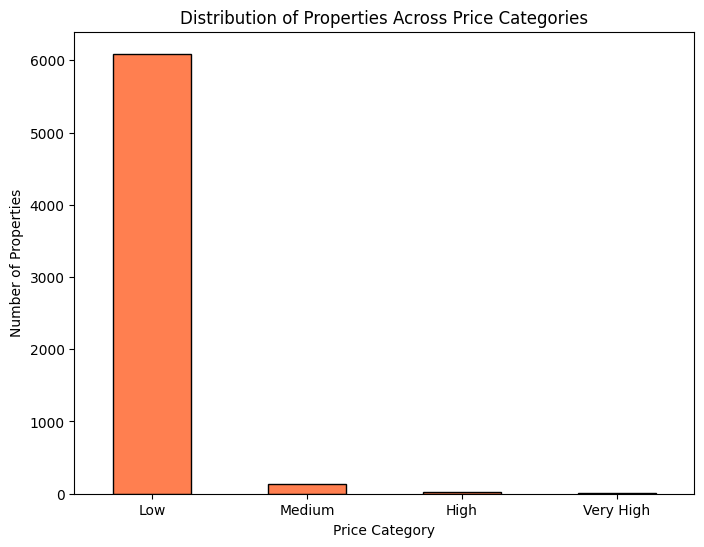


Distribution of Properties Across Categories:
- Low: 6092 properties (97.38%)
- Medium: 139 properties (2.22%)
- High: 18 properties (0.29%)
- Very High: 7 properties (0.11%)

Analysis: Significant imbalance detected. Consider balancing the dataset during model training.


In [29]:
# Step 1: Analyze the range of prices
min_price = train_data['Price'].min()
max_price = train_data['Price'].max()
print(f"Price range: {min_price} - {max_price}")

# Step 2: Adjust price bins based on the price range
# I have made bins according to maximun price and minimum price.
#Below is the implemenattion of how the code is calculating and making the bin price.
price_bins = [min_price, min_price + 0.25 * (max_price - min_price),
              min_price + 0.5 * (max_price - min_price),
              min_price + 0.75 * (max_price - min_price), max_price]
price_labels = ['Low', 'Medium', 'High', 'Very High']

# Categorize the target variable
train_data['Price_Category'] = pd.cut(train_data['Price'], bins=price_bins, labels=price_labels, include_lowest=True)

# Step 3: Visualize distribution across categories
category_counts = train_data['Price_Category'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Distribution of Properties Across Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Number of Properties')
plt.xticks(rotation=0)
plt.show()

# Step 4: Discuss Imbalance
total_properties = len(train_data)
print("\nDistribution of Properties Across Categories:")
for category, count in category_counts.items():
    print(f"- {category}: {count} properties ({(count / total_properties) * 100:.2f}%)")

# Handle ZeroDivisionError: Check if all categories have at least one property
if category_counts.min() > 0:
    imbalance_ratio = category_counts.max() / category_counts.min()
    if imbalance_ratio > 2:
        print("\nAnalysis: Significant imbalance detected. Consider balancing the dataset during model training.")
    else:
        print("\nAnalysis: Distribution across categories is relatively balanced.")
else:
    print("\nAnalysis: Some categories have zero properties. Consider redefining the price bins to better align with the data distribution.")


Original class distribution: Counter({'Low': 6092, 'Medium': 139, 'High': 18, 'Very High': 7})


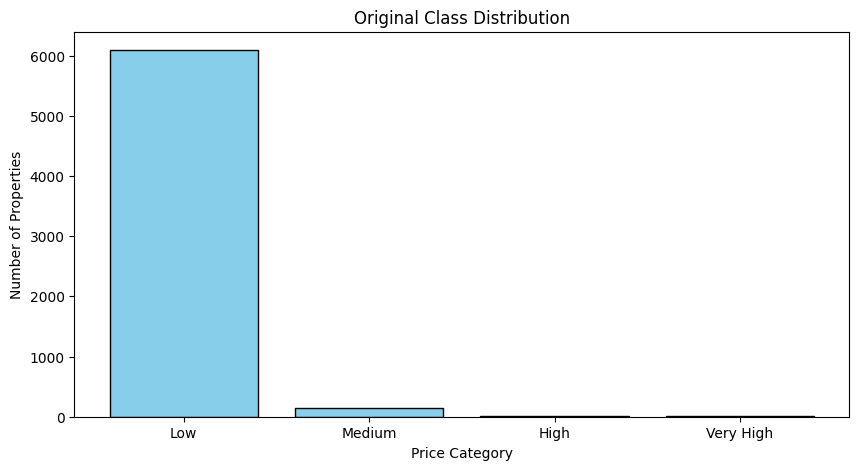


After Random Undersampling:
Class distribution: Counter({'High': 7, 'Low': 7, 'Medium': 7, 'Very High': 7})


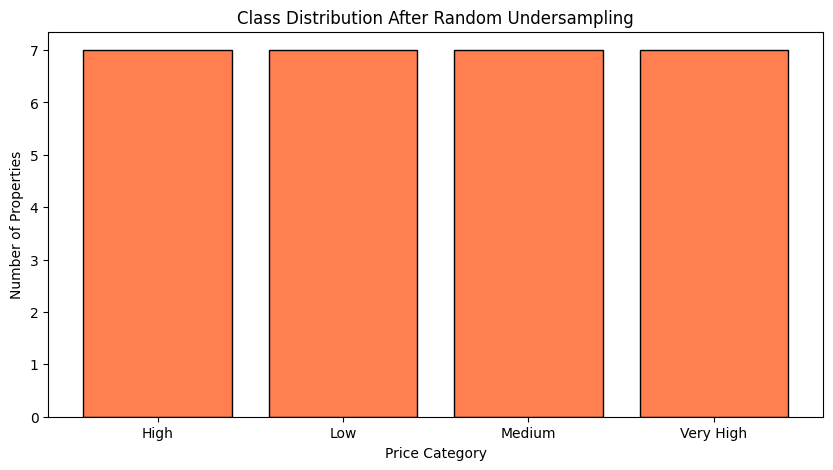


After Random Oversampling:
Class distribution: Counter({'Low': 6092, 'Medium': 6092, 'High': 6092, 'Very High': 6092})


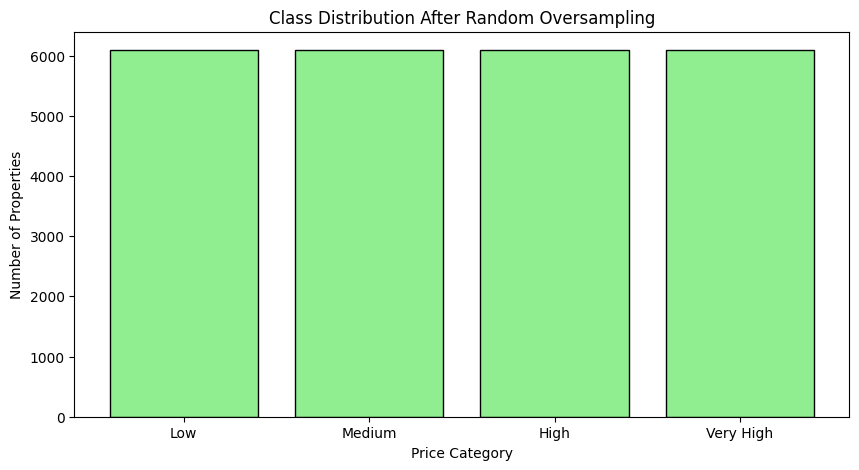


Datasets saved as 'undersampled_train.csv' and 'oversampled_train.csv'.


In [30]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Separate features and target
X = train_data.drop(columns=['Price_Category'])
y = train_data['Price_Category']

# Step 2: Analyze original class distribution
original_counts = Counter(y)
print("Original class distribution:", original_counts)

# Plot original class distribution
plt.figure(figsize=(10, 5))
plt.bar(original_counts.keys(), original_counts.values(), color='skyblue', edgecolor='black')
plt.title('Original Class Distribution')
plt.xlabel('Price Category')
plt.ylabel('Number of Properties')
plt.show()

# Step 3: Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

undersampled_counts = Counter(y_under)
print("\nAfter Random Undersampling:")
print("Class distribution:", undersampled_counts)

# Plot undersampled class distribution
plt.figure(figsize=(10, 5))
plt.bar(undersampled_counts.keys(), undersampled_counts.values(), color='coral', edgecolor='black')
plt.title('Class Distribution After Random Undersampling')
plt.xlabel('Price Category')
plt.ylabel('Number of Properties')
plt.show()

# Step 4: Random Oversampling
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)

oversampled_counts = Counter(y_over)
print("\nAfter Random Oversampling:")
print("Class distribution:", oversampled_counts)

# Plot oversampled class distribution
plt.figure(figsize=(10, 5))
plt.bar(oversampled_counts.keys(), oversampled_counts.values(), color='lightgreen', edgecolor='black')
plt.title('Class Distribution After Random Oversampling')
plt.xlabel('Price Category')
plt.ylabel('Number of Properties')
plt.show()

# Step 5: Save the resampled datasets for further processing
undersampled_data = pd.concat([pd.DataFrame(X_under), pd.DataFrame(y_under, columns=['Price_Category'])], axis=1)
oversampled_data = pd.concat([pd.DataFrame(X_over), pd.DataFrame(y_over, columns=['Price_Category'])], axis=1)

undersampled_data.to_csv("undersampled_train.csv", index=False)
oversampled_data.to_csv("oversampled_train.csv", index=False)

print("\nDatasets saved as 'undersampled_train.csv' and 'oversampled_train.csv'.")


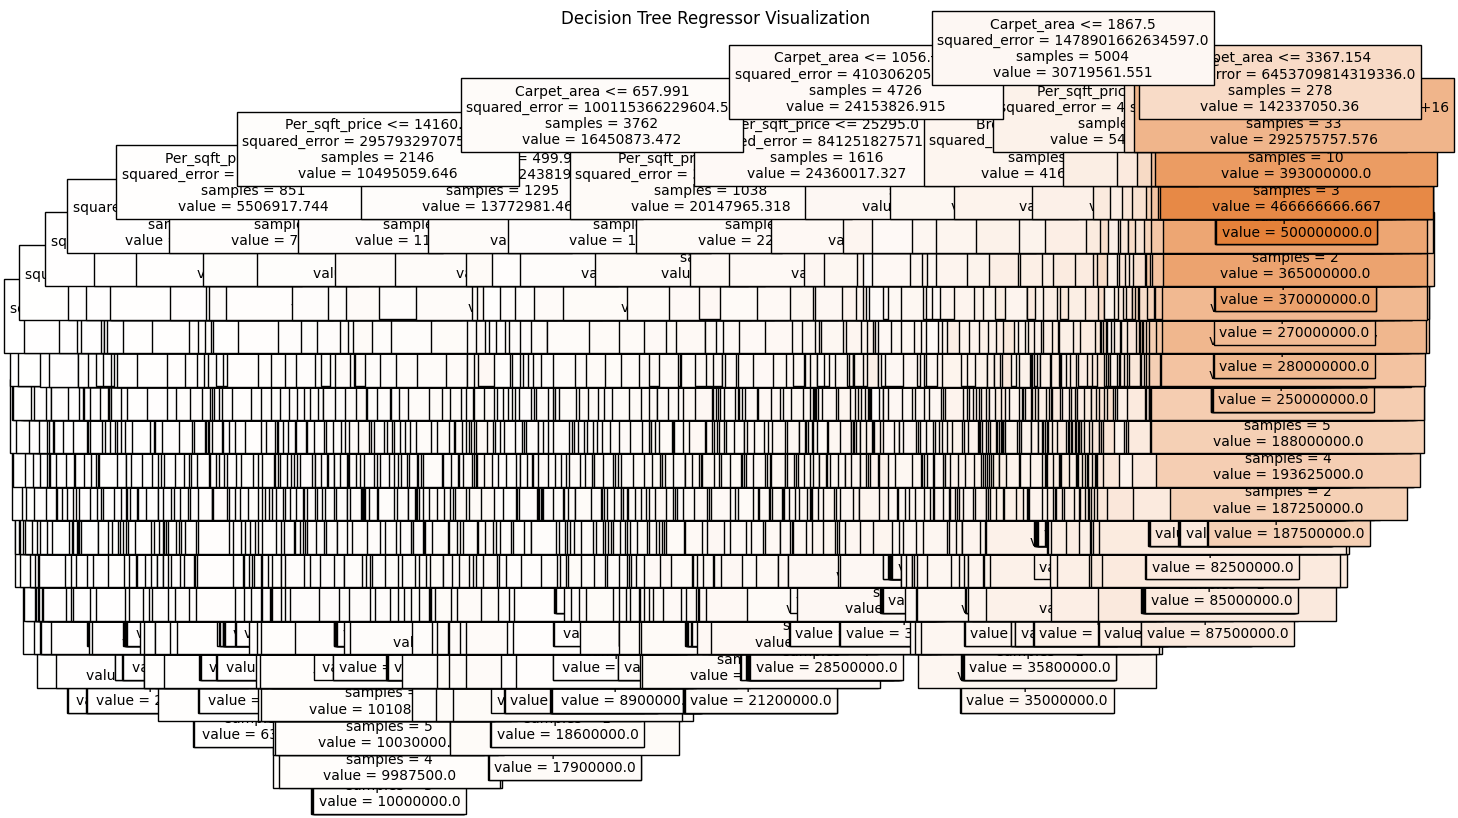

In [31]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Prepare the data (Use the resampled dataset or original dataset)
# Assuming we're using the original dataset (if you want to use undersampled or oversampled data, replace the `train_data` below)
X = train_data.drop(columns=['Price', 'Price_Category'])  # Features
y = train_data['Price']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X.columns, fontsize=10)
plt.title("Decision Tree Regressor Visualization")
plt.show()

# Step 5: Model details and explanation
print(f"Model Depth: {model.get_depth()}")
print(f"Number of Leaves: {model.get_n_leaves()}")


In [ ]:
#FOE BETTER VISULAISATION I HAVE REDUCED THE DEPTH OF THE GRAPH TO 5

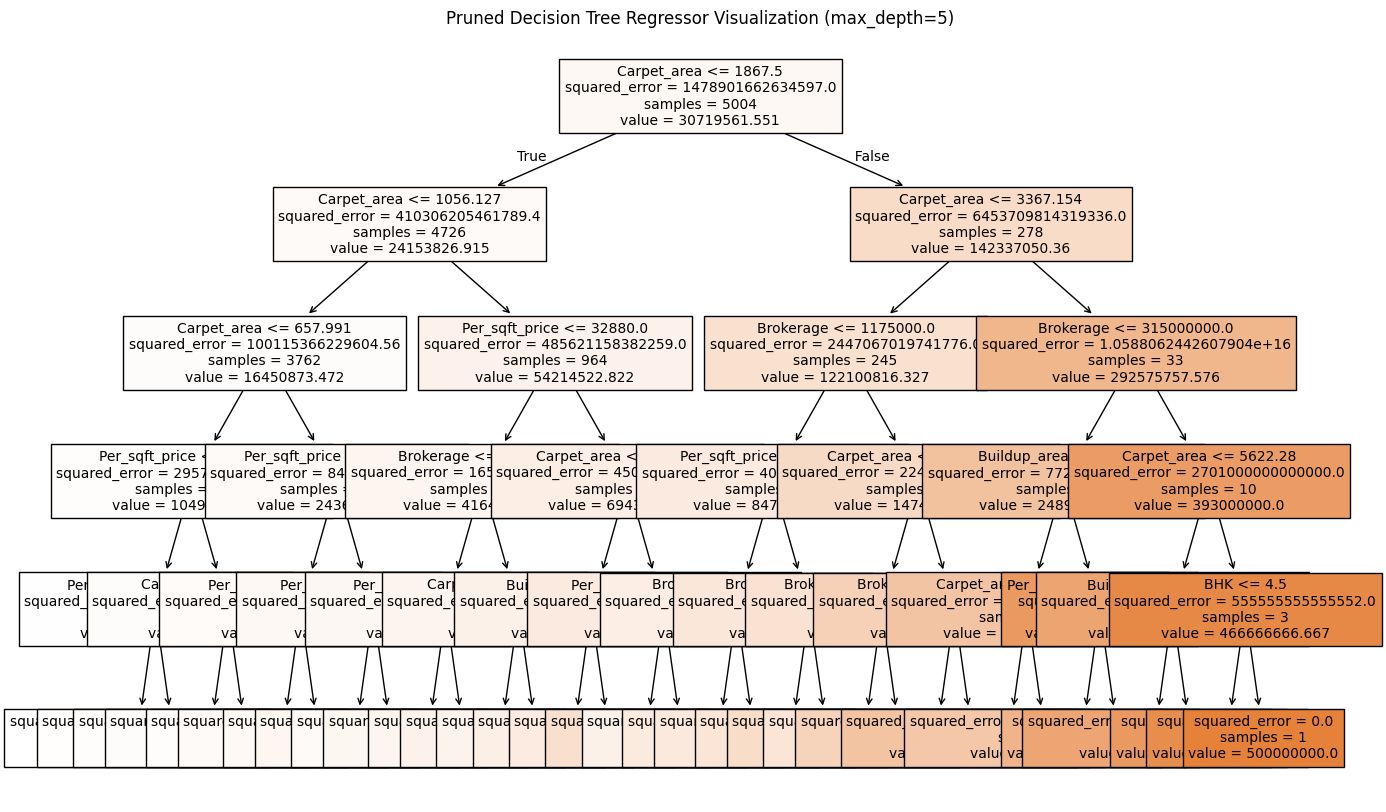

Model Depth: 5
Number of Leaves: 32


In [32]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Prepare the data (Use the resampled dataset or original dataset)
# Assuming we're using the original dataset (if you want to use undersampled or oversampled data, replace the `train_data` below)
X = train_data.drop(columns=['Price', 'Price_Category'])  # Features
y = train_data['Price']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the Decision Tree Regressor with max_depth=5
model = DecisionTreeRegressor(random_state=42, max_depth=5)
model.fit(X_train, y_train)

# Step 4: Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(model, filled=True, feature_names=X.columns, fontsize=10)
plt.title("Pruned Decision Tree Regressor Visualization (max_depth=5)")
plt.show()

# Step 5: Model details and explanation
print(f"Model Depth: {model.get_depth()}")
print(f"Number of Leaves: {model.get_n_leaves()}")


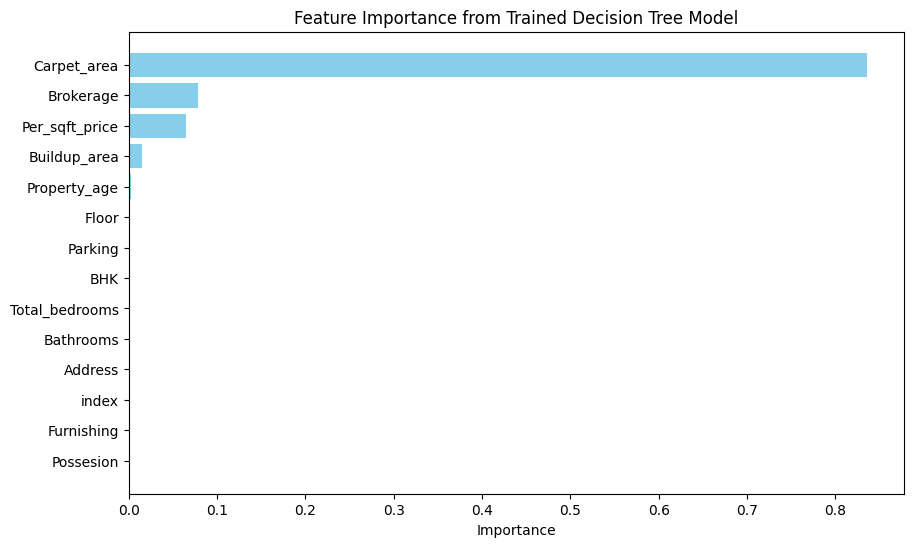

           Feature  Importance
5      Carpet_area    0.835556
9        Brokerage    0.078187
11  Per_sqft_price    0.064567
4     Buildup_area    0.015507
7     Property_age    0.002735
10           Floor    0.001203
8          Parking    0.001165
12             BHK    0.000297
13  Total_bedrooms    0.000239
6        Bathrooms    0.000221
1          Address    0.000185
0            index    0.000127
3       Furnishing    0.000011
2        Possesion    0.000000


In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare the data (Use the resampled dataset or original dataset)
# Assuming we're using the original dataset (replace `train_data` with your dataset if needed)
X = train_data.drop(columns=['Price', 'Price_Category'])  # Features
y = train_data['Price']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 4: Extract the feature importances
importances = model.feature_importances_

# Step 5: Create a DataFrame to view the feature importances with the feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Step 6: Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 7: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Trained Decision Tree Model')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()

# Step 8: Display the feature importances (optional)
print(feature_importance_df)


Default Model MSE: 52884603996006.39
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util


Best Hyperparameters found using Grid Search:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Tuned Model MSE: 71714878242030.88

MSE Improvement: -18830274246024.484


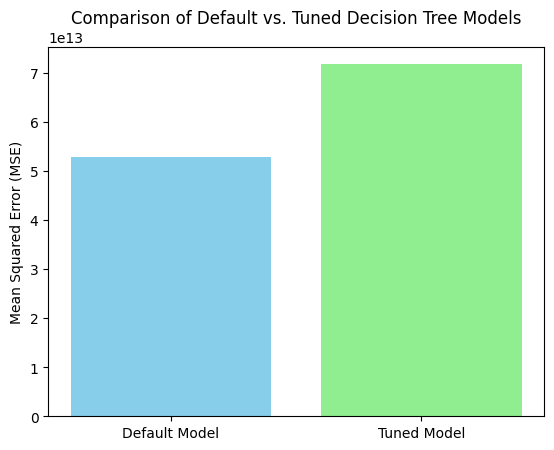

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Prepare the data (Use the resampled dataset or original dataset)
X = train_data.drop(columns=['Price', 'Price_Category'])  # Features
y = train_data['Price']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the default Decision Tree Regressor
default_model = DecisionTreeRegressor(random_state=42)
default_model.fit(X_train, y_train)

# Step 4: Make predictions with the default model
y_pred_default = default_model.predict(X_test)

# Step 5: Evaluate the default model
mse_default = mean_squared_error(y_test, y_pred_default)
print(f"Default Model MSE: {mse_default}")

# Step 6: Define the hyperparameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2']  # Number of features to consider
}

# Step 7: Initialize the GridSearchCV with the DecisionTreeRegressor
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error',  # Minimize MSE
                           n_jobs=-1,  # Use all cores for parallel processing
                           verbose=1)

# Step 8: Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Step 9: Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print("\nBest Hyperparameters found using Grid Search:")
print(best_params)

# Step 10: Train the Decision Tree with the best parameters
tuned_model = grid_search.best_estimator_

# Step 11: Make predictions with the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Step 12: Evaluate the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print(f"Tuned Model MSE: {mse_tuned}")

# Step 13: Compare the performance (MSE) of the default model and the tuned model
print(f"\nMSE Improvement: {mse_default - mse_tuned}")

# Step 14: Visualize the comparison of default vs. tuned model performance
labels = ['Default Model', 'Tuned Model']
mse_values = [mse_default, mse_tuned]

plt.bar(labels, mse_values, color=['skyblue', 'lightgreen'])
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of Default vs. Tuned Decision Tree Models")
plt.show()


Unpruned Tree MSE: 52884603996006.39
Best alpha for pruning: 0.0
Pruned Tree MSE: 52884603996006.39


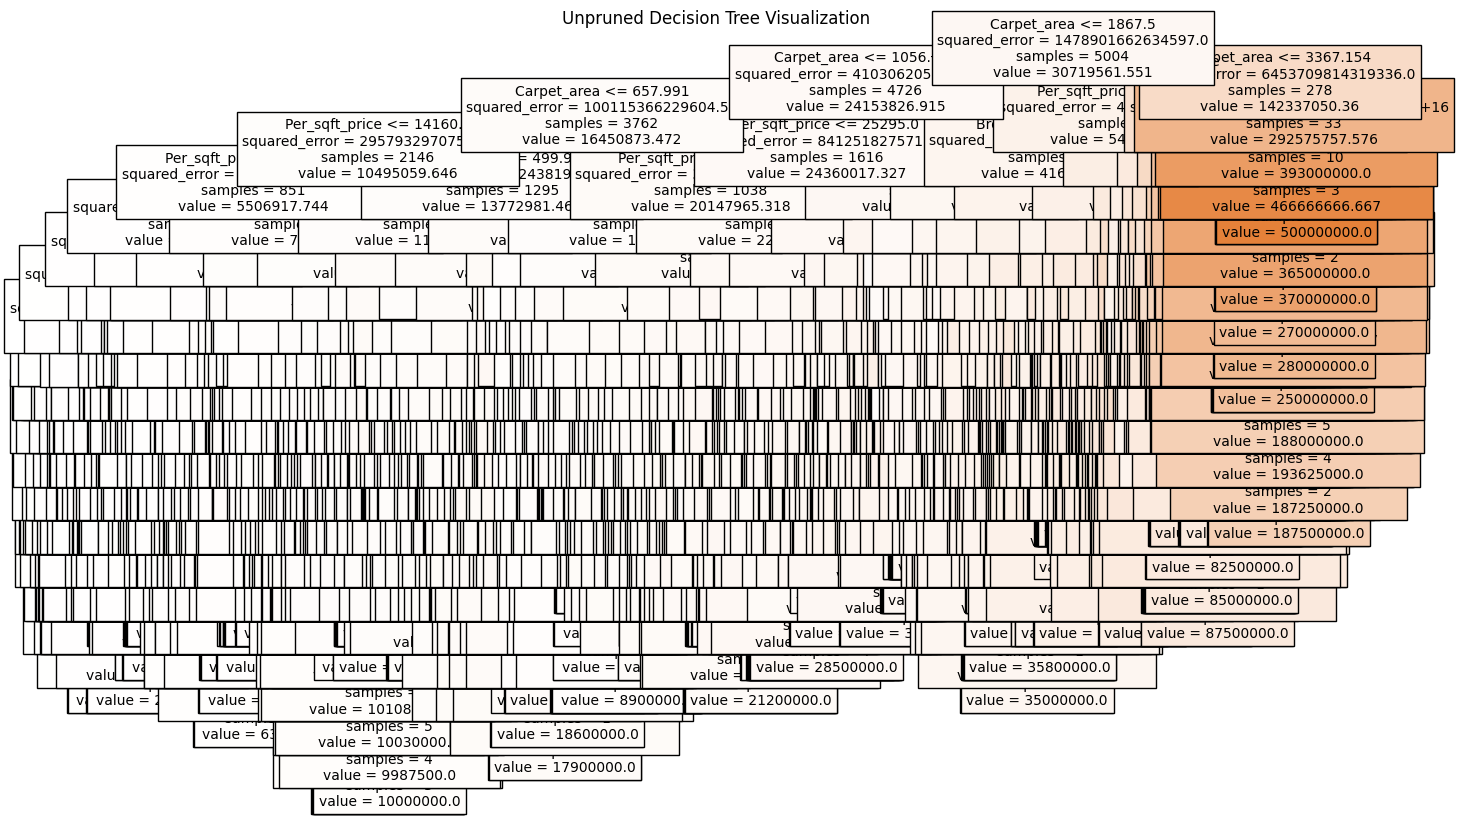

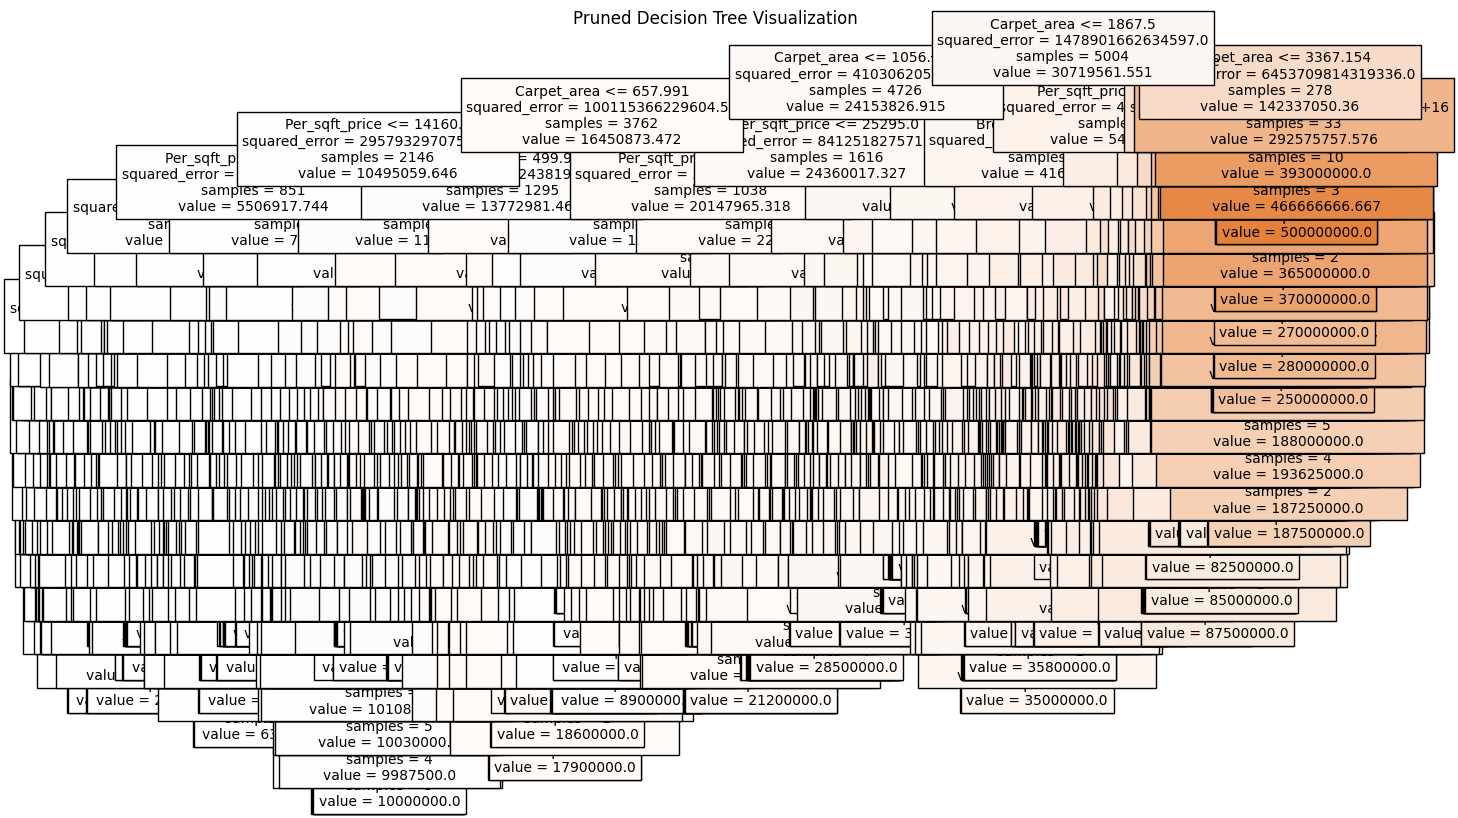


MSE Improvement (Unpruned - Pruned): 0.0


In [39]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Prepare the data (use the resampled dataset or original dataset)
X = train_data.drop(columns=['Price', 'Price_Category'])  # Features
y = train_data['Price']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Decision Tree without pruning (default tree)
unpruned_tree = DecisionTreeRegressor(random_state=42)
unpruned_tree.fit(X_train, y_train)

# Step 4: Evaluate the unpruned tree
y_pred_unpruned = unpruned_tree.predict(X_test)
mse_unpruned = mean_squared_error(y_test, y_pred_unpruned)
print(f"Unpruned Tree MSE: {mse_unpruned}")

# Step 5: Get the effective alpha values (ccp_alpha) from the path
path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Step 6: Select a smaller range of alpha values for pruning
# Instead of using all values, take only the first 10 or a custom number
ccp_alphas = ccp_alphas[:10]  # Limit to first 10 alphas (adjust as needed)

# Step 7: Perform cross-validation for different alpha values to find the best one
cv_scores = []
for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    pruned_tree.fit(X_train, y_train)
    # Perform 5-fold cross-validation and use parallel processing (n_jobs=-1)
    cv_scores.append(np.mean(cross_val_score(pruned_tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)))

# Step 8: Find the best alpha value based on cross-validation performance
best_alpha = ccp_alphas[np.argmax(cv_scores)]
print(f"Best alpha for pruning: {best_alpha}")

# Step 9: Train the pruned tree using the best alpha
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Step 10: Evaluate the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"Pruned Tree MSE: {mse_pruned}")

# Step 11: Visualize the unpruned tree
plt.figure(figsize=(15, 10))
plot_tree(unpruned_tree, filled=True, feature_names=X.columns, fontsize=10)
plt.title("Unpruned Decision Tree Visualization")
plt.show()

# Step 12: Visualize the pruned tree
plt.figure(figsize=(15, 10))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, fontsize=10)
plt.title("Pruned Decision Tree Visualization")
plt.show()

# Step 13: Compare performance (MSE) of unpruned and pruned models
print(f"\nMSE Improvement (Unpruned - Pruned): {mse_unpruned - mse_pruned}")


In [40]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Step 1: Train a decision tree regressor (default model)
model = DecisionTreeRegressor(random_state=42)

# Step 2: Perform K-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Step 3: Calculate the average cross-validation score
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Step 4: Print the results
print(f"Cross-Validation Mean MSE: {-cv_mean}")
print(f"Cross-Validation Standard Deviation: {cv_std}")


Cross-Validation Mean MSE: 92410509539269.92
Cross-Validation Standard Deviation: 62484421389532.22


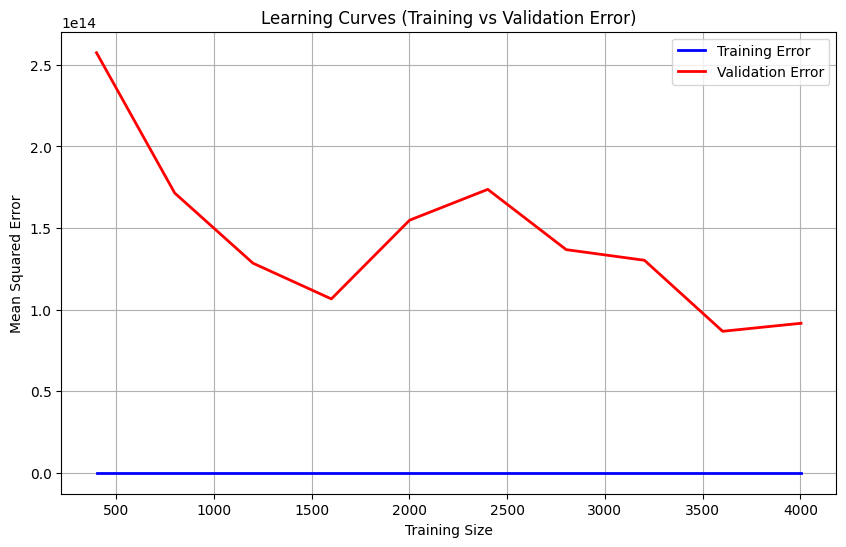

In [41]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Step 1: Create the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Step 2: Calculate the mean and standard deviation for the training and validation errors
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Step 3: Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error', color='blue', lw=2)
plt.plot(train_sizes, val_errors, label='Validation Error', color='red', lw=2)
plt.title("Learning Curves (Training vs Validation Error)")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
from sklearn.model_selection import GridSearchCV

# Assuming `grid_search` is your GridSearchCV object from hyperparameter tuning
best_model = grid_search.best_estimator_

# Now, use the `best_model` to evaluate the performance
y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print out the results
print("Training Metrics:")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"R-squared (R²): {r2_train}")

print("\nTest Metrics:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R-squared (R²): {r2_test}")


Training Metrics:
Mean Squared Error (MSE): 19116172596973.85
Mean Absolute Error (MAE): 989669.3426211412
R-squared (R²): 0.9870740745784828

Test Metrics:
Mean Squared Error (MSE): 71714878242030.88
Mean Absolute Error (MAE): 1815159.4306252855
R-squared (R²): 0.9433609818478109


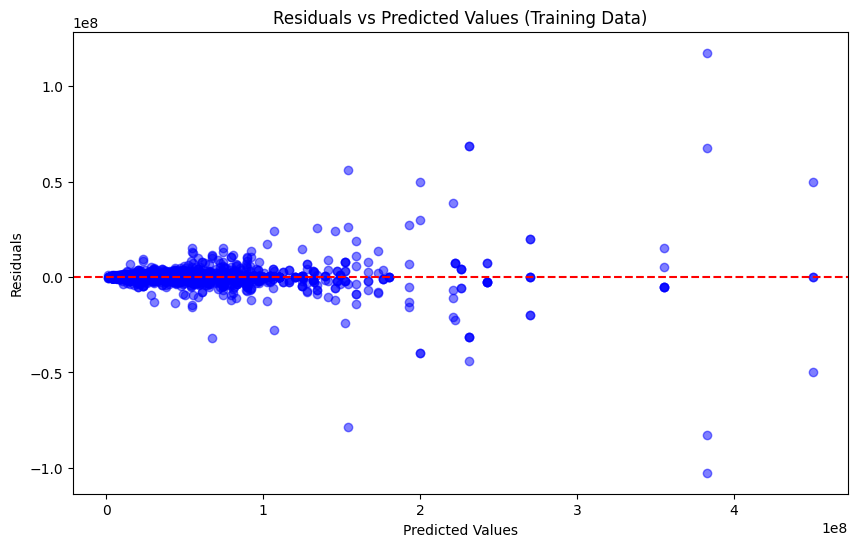

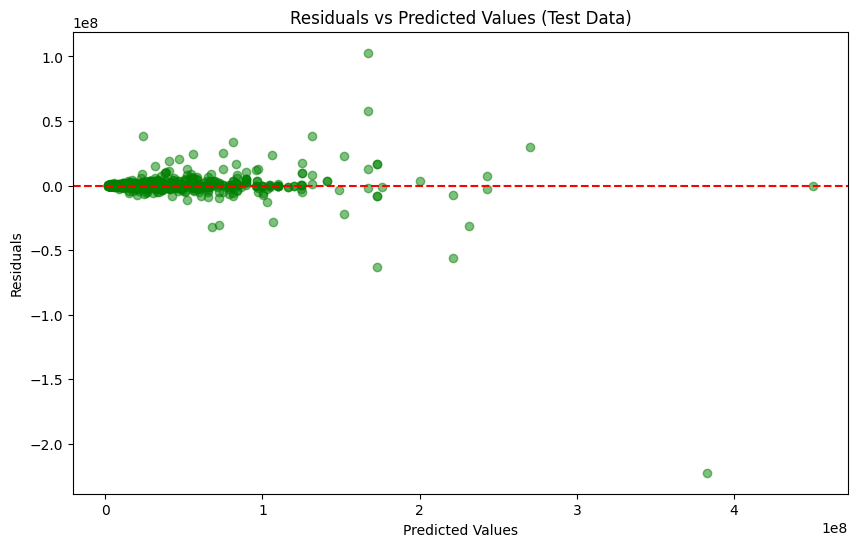

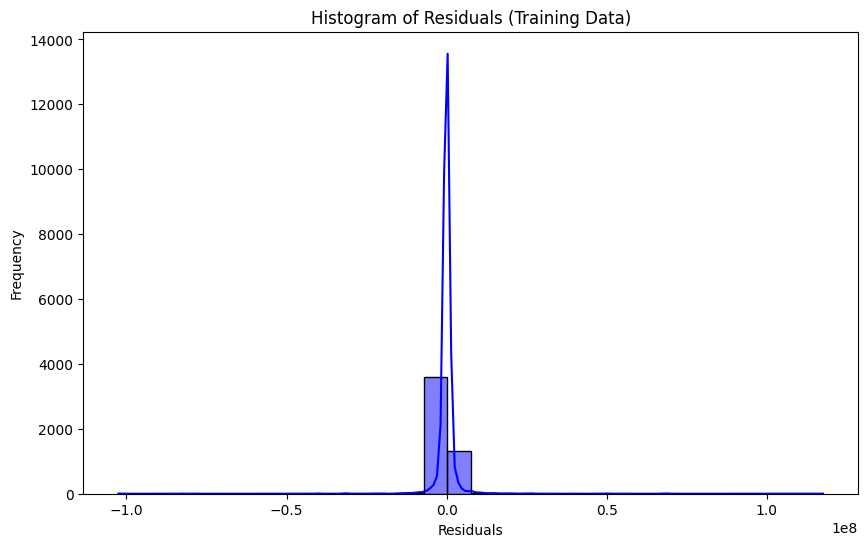

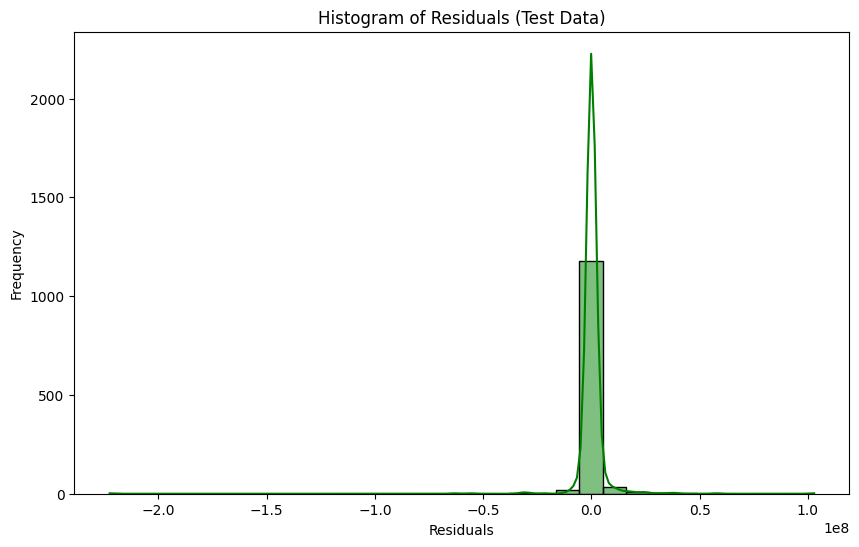

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate residuals
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# 1. Residual Plot for Training Data
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, residuals_train, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Line at 0 for reference
plt.title('Residuals vs Predicted Values (Training Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# 2. Residual Plot for Test Data
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals_test, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Line at 0 for reference
plt.title('Residuals vs Predicted Values (Test Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# 3. Histogram of Residuals for Training Data
plt.figure(figsize=(10, 6))
sns.histplot(residuals_train, kde=True, color='blue', bins=30)
plt.title('Histogram of Residuals (Training Data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 4. Histogram of Residuals for Test Data
plt.figure(figsize=(10, 6))
sns.histplot(residuals_test, kde=True, color='green', bins=30)
plt.title('Histogram of Residuals (Test Data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



In [47]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Example dataset: Create a balanced dataset or use your own dataset
# X, y = <your dataset>

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to handle imbalance
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Train a model (RandomForestClassifier as an example)
rf = RandomForestClassifier(random_state=42)

# Evaluate using RandomOverSampler
rf.fit(X_train_ros, y_train_ros)
y_pred_ros = rf.predict(X_test)

print("Performance with RandomOverSampler:")
print(classification_report(y_test, y_pred_ros))


Performance with RandomOverSampler:
              precision    recall  f1-score   support

     1699000       0.00      0.00      0.00         1
     1800000       1.00      1.00      1.00         1
     1850000       1.00      1.00      1.00         1
     2000000       1.00      1.00      1.00         1
     2150000       0.00      0.00      0.00         0
     2200000       1.00      1.00      1.00         2
     2210000       1.00      1.00      1.00         1
     2300000       1.00      1.00      1.00         1
     2350000       0.00      0.00      0.00         0
     2400000       1.00      1.00      1.00         1
     2430000       0.00      0.00      0.00         1
     2440000       0.00      0.00      0.00         1
     2450000       0.00      0.00      0.00         0
     2500000       0.50      0.50      0.50         2
     2520000       0.00      0.00      0.00         0
     2552000       0.00      0.00      0.00         1
     2570000       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 2: Evaluate the Random Forest Model
y_pred_rf = rf_model.predict(X_test)

# Metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf}")
print(f"Random Forest - MAE: {mae_rf}")
print(f"Random Forest - R2: {r2_rf}")

# Step 3: Evaluate the Decision Tree Model
y_pred_dt = unpruned_tree.predict(X_test)

# Metrics for Decision Tree
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree - MSE: {mse_dt}")
print(f"Decision Tree - MAE: {mae_dt}")
print(f"Decision Tree - R2: {r2_dt}")


Random Forest - MSE: 21995507692382.99
Random Forest - MAE: 1112473.3785942493
Random Forest - R2: 0.9826283751713134
Decision Tree - MSE: 52884603996006.39
Decision Tree - MAE: 1644679.7124600639
Decision Tree - R2: 0.9582327667685333
